## Import required libraries.

In [1]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator,LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [238]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\junk')
os.chdir(location)
input_geotiff = gdal.Open('fann_2013_1m.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / working_resolution, order = 1)
input_outlets = gdal.Open('core_nodes_1m_adjusted.tif')
gh = np.array(input_outlets.GetRasterBand(1).ReadAsArray()).astype('uint8')


In [239]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def meanFilter(gidded_data):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = gidded_data[central_value]                        
    mean = np.nanmean(gidded_data)#Count number of values greater than centroid value
    return mean
def maxFilter(gidded_data):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = gidded_data[central_value]                        
    max_value = np.amax(gidded_data)#Count number of values greater than centroid value
    return max_value
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    keys = gh_nodes
    for i in keys:
        area_grid_copy = np.copy(area_grid)
        corresponding_grid_cell = np.isin(gn, i).astype(bool)
        area_grid_copy[~corresponding_grid_cell] = np.nan
        area = np.unique(area_grid_copy[~np.isnan(area_grid_copy)])[0]
        area_dict[i] = area
    return area_dict

In [240]:
catchment_area_grids = xr.Dataset()
direction_list = ['East', 'North', 'West', 'South',
                  'North East', 'North West', 'South West', 'South East'];
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [241]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))

In [242]:
find_nodes = np.multiply(gh, grid_nodes);

In [243]:
gh_array = np.unique(find_nodes);

In [244]:
gh_list = gh_array.tolist();
gh_list.remove(0);

In [245]:
len(gh_list)

483

In [246]:
gh_list

[6369407,
 8000074,
 8402506,
 9130277,
 9172835,
 9183765,
 9370132,
 9370420,
 9500595,
 9554351,
 9618717,
 9620569,
 9827099,
 9956490,
 10216636,
 10217375,
 10368938,
 10498956,
 10684314,
 10728525,
 10740264,
 10903494,
 10934359,
 10956490,
 11076555,
 11238350,
 11283972,
 11336737,
 11414343,
 11435778,
 11511019,
 11511528,
 11718121,
 11836819,
 11902675,
 11978126,
 11990044,
 12023550,
 12208442,
 12271787,
 12315595,
 12337804,
 12523812,
 12740838,
 13077265,
 13097728,
 13130326,
 13382787,
 13390853,
 13490070,
 13773468,
 13792279,
 13839467,
 14064625,
 14185493,
 14218099,
 14250724,
 14426502,
 14546211,
 14574766,
 14597408,
 14608727,
 14837309,
 14850011,
 14902260,
 14988485,
 15011325,
 15042582,
 15120088,
 15185337,
 15196215,
 15339295,
 15359202,
 15369573,
 15630757,
 15868935,
 15894073,
 16000150,
 16010608,
 16014084,
 16220663,
 16272530,
 16348638,
 16349480,
 16576266,
 16587812,
 16762758,
 16782356,
 16814038,
 16838910,
 16883909,
 16945936,
 1

In [247]:
start = timeit.default_timer()

catchment_area_node_list = []
distance_from_node = 100

upslope_divergence_dict = {}
step_size = 5
comparison_distance = 5
change_detection_factor = 0.5

for i in gh_list:
    print(i)

    current_node = i
    result = np.where(grid_nodes == current_node)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Set a distance from the node to define the size of the subset taken (size of subset will be twice plus 1)
    
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # centraL grid node of the subset.
    subset_row_top = int(row_index - distance_from_node)
    subset_row_bot = int(row_index + distance_from_node) + 1
    subset_col_left = int(col_index - distance_from_node)
    subset_col_right = int(col_index + distance_from_node) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    dem_subset_copy = np.copy(input_DEM);
    dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]
    
    
    #################################################################################################
    # Find the latitude and longitude index positions of the gully head node in the subset DEM.
    node_lat = distance_from_node + offset_row_top
    node_lon = distance_from_node + offset_col_left
    #################################################################################################  
    # Run M8 for the subset DEM.
    flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
    
    rows_sub = flow_acc_surf_sub.shape[0];
    cols_sub = flow_acc_surf_sub.shape[1];
    mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
    z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
    
    sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
    sfb.run_one_step();
    fa = FlowAccumulator(mg1,
                        surface = 'topographic__elevation',
                        flow_director = 'FlowDirectorMFD',
                        diagonals = True);
    
    fa.run_one_step()
    fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
    fd.run_one_step()
    #################################################################################################
    # Extract required grid properties
    da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
    frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
    drainage_area = da.reshape(mg1.shape);
    frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
    flow_rec_surf_rows = cols_sub * rows_sub;
    flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
    all_receiver_proportions = np.copy(frp);
    grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
    #################################################################################################
    central_node = grid_nodes_sub[node_lat, node_lon]
    # Specific the size of the area to be checked. This represents a physical distance from the 
    # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
    #catchment_area = da.reshape(mg1.shape)
    #mean_catchment_area = generic_filter(catchment_area, meanFilter, 
    #                    footprint= circleWindow(2), mode='nearest');
    #flattened_mean_catchment_area = mean_catchment_area.reshape(da.shape)
    
    # This value is used to initialise the search.
    catchment_outlet_id = central_node
    
    # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
    # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
    # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.
    
    # Create a grid of node value sfor the subset DEM.
    node_location = mg1.nodes.reshape(da.shape);
    node_area_dict = {}
    node_full_area_dict = {}
    node_mean_area_dict = {}
    
    # This value is used to initialise the search.

    # Initate an outer loop that iterates through every distance interval from the outlet.
    watershed_grid_cells = []
    
    ordered_node_list = []

    for d in range(0, distance_from_node):
        # Just look at watershed grid cells here.

        # Create a list initially containing only the outlet grid cell.
        if d == 0:
            candidate_gridcells = [catchment_outlet_id];
        else:
            candidate_gridcells = list(set(upstream_nodes));
        # Empty the list of upsteam nodes.
        upstream_node_dict = {};
        upstream_full_area_dict = {};
        upstream_mean_area_dict = {}
        # Intiate a new loop to check every gridcell at the current interval distance.
        
        for grid_cell in candidate_gridcells:
            # Check each flow direction of the current grid cell.The second dimension of the 
            # flow__receiver_node object will always be size == 8.
            for j in range(frn.shape[1]):
                # Return all rows (grid nodes) that send any flow to the target grid cell.
                # Note: This can only be one grid cell because the prgram is looping through
                # each direction one at a time so only one grid cell can be sending flow from any
                # one given direction.
                flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                # Check if the current direction contributes flow. If not, do nothing. 
                # Else, append to dictionary.
                if flow_from_whole_grid_cell.shape[0] == 0:
                    pass
                else:
                    # Below variable finds the row position of the flow_from_direction gridcell
                    # in the flow__receiver_node array. This corresponds to the contributing
                    # cell's node id.
                    node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                    #Find the proportion of flow leaving the donor node and heading toward 
                    # the current grid cell.
                    proportion_of_flow = frp[node_id_value, j]
                    # Create a boolean array to use as mask on drainage area.
                    isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                    node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                    #node_mean_drainage_area =  np.amax(np.multiply(isolate_candidate_grid_cells, flattened_mean_catchment_area))
                    node_directional_drainage_area = node_drainage_area * proportion_of_flow
                    upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                    # This looks at the average catchment area in a window around the primary flow direction grid cell.
                    # This was done to reduce the variabiltiy in values from one grid cell to the next.
                    #upstream_mean_area_dict.update({node_id_value:node_mean_drainage_area});

            if len(upstream_node_dict) == 0:
                print ("dictionary empty")
            else:
                primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                upstream_nodes = []
                upstream_nodes.append(primary_flow_direction_id);
                ordered_node_list.append(primary_flow_direction_id);
                watershed_grid_cells.append(primary_flow_direction_id);
                node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                #node_mean_area_dict[primary_flow_direction_id] = upstream_mean_area_dict[primary_flow_direction_id]
    area_along_central_drainage_line = []
    for key, value in node_area_dict.items():
        area_along_central_drainage_line.append(value)
    median_area_along_central_drainage_line = ndimage.median_filter(area_along_central_drainage_line, size=5)
    print(len(median_area_along_central_drainage_line))
    required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
    if len(median_area_along_central_drainage_line) < required_number_of_grid_cells:
        upslope_divergence_dict[i] = 'not enough grid cells'
    else:
        divergence_occuring = upslopeDivergence(median_area_along_central_drainage_line, change_detection_factor, 
                                                step_size, comparison_distance)
        upslope_divergence_dict[i] = divergence_occuring

stop=timeit.default_timer()
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

6369407
100
8000074
100
8402506
100
9130277
100
9172835
100
9183765
100
9370132
100
9370420
100
9500595
100
9554351
100
9618717
100
9620569
100
9827099
dictionary empty
dictionary empty
dictionary empty
97
9956490
100
10216636
100
10217375
100
10368938
100
10498956
100
10684314
100
10728525
100
10740264
100
10903494
100
10934359
100
10956490
100
11076555
100
11238350
100
11283972
100
11336737
100
11414343
100
11435778
100
11511019
100
11511528
100
11718121
100
11836819
100
11902675
100
11978126
100
11990044
100
12023550
dictionary empty
dictionary empty
dictionary empty
dictionary empty
dictionary empty
95
12208442
100
12271787
100
12315595
100
12337804
100
12523812
100
12740838
100
13077265
100
13097728
100
13130326
100
13382787
100
13390853
100
13490070
100
13773468
100
13792279
100
13839467
100
14064625
100
14185493
100
14218099
100
14250724
100
14426502
100
14546211
100
14574766
100
14597408
100
14608727
100
14837309
100
14850011
100
14902260
100
14988485
100
15011325
100
15042582


In [248]:
upslope_divergence_dict

{6369407: 0,
 8000074: 1,
 8402506: 0,
 9130277: 0,
 9172835: 1,
 9183765: 0,
 9370132: 0,
 9370420: 1,
 9500595: 0,
 9554351: 0,
 9618717: 0,
 9620569: 0,
 9827099: 0,
 9956490: 1,
 10216636: 0,
 10217375: 1,
 10368938: 0,
 10498956: 1,
 10684314: 0,
 10728525: 0,
 10740264: 1,
 10903494: 0,
 10934359: 1,
 10956490: 0,
 11076555: 0,
 11238350: 1,
 11283972: 0,
 11336737: 0,
 11414343: 1,
 11435778: 1,
 11511019: 1,
 11511528: 1,
 11718121: 0,
 11836819: 0,
 11902675: 1,
 11978126: 0,
 11990044: 0,
 12023550: 1,
 12208442: 0,
 12271787: 1,
 12315595: 0,
 12337804: 1,
 12523812: 1,
 12740838: 0,
 13077265: 1,
 13097728: 1,
 13130326: 1,
 13382787: 0,
 13390853: 1,
 13490070: 1,
 13773468: 1,
 13792279: 1,
 13839467: 1,
 14064625: 0,
 14185493: 0,
 14218099: 1,
 14250724: 1,
 14426502: 0,
 14546211: 1,
 14574766: 0,
 14597408: 1,
 14608727: 0,
 14837309: 1,
 14850011: 0,
 14902260: 0,
 14988485: 0,
 15011325: 1,
 15042582: 0,
 15120088: 0,
 15185337: 0,
 15196215: 0,
 15339295: 0,
 15359

In [250]:
catchment_area_dict

{6391156: 6369407,
 8000074: 8000074,
 8391634: 8402506,
 9097658: 9130277,
 9162023: 9183765,
 9194578: 9172835,
 9316061: 9370420,
 9370133: 9370132,
 9500595: 9500595,
 9565224: 9554351,
 9618717: 9618717,
 9620570: 9620569,
 9859722: 9827099,
 9956490: 9956490,
 10216636: 10216636,
 10228251: 10217375,
 10412428: 10368938,
 10520704: 10498956,
 10684315: 10684314,
 10728525: 10728525,
 10772882: 10740264,
 10925239: 10903494,
 10966975: 10934359,
 10967362: 10956490,
 11076555: 11076555,
 11216606: 11238350,
 11316593: 11283972,
 11347611: 11336737,
 11435779: 11435778,
 11446962: 11414343,
 11489783: 11511528,
 11511019: 11511019,
 11718121: 11718121,
 11858565: 11836819,
 11957039: 11902675,
 11978126: 11978126,
 11979172: 11990044,
 12023549: 12023550,
 12164946: 12208442,
 12315281: 12271787,
 12315594: 12315595,
 12370422: 12337804,
 12491192: 12523812,
 12729966: 12740838,
 13077265: 13077265,
 13097729: 13097728,
 13130326: 13130326,
 13382786: 13382787,
 13401726: 13390853,

In [253]:
def getKeysByValues(dictOfElements, listOfValues):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] in listOfValues:
            listOfKeys.append(item[0])
    return  listOfKeys 

In [260]:
non_adjusted_divergence_nodes = getKeysByValues(catchment_area_dict, divergence_list)

In [261]:
non_adjusted_convergence_nodes = getKeysByValues(catchment_area_dict, convergence_list)

In [271]:
non_adjusted_convergence_nodes

[6391156,
 8391634,
 9097658,
 9162023,
 9370133,
 9500595,
 9565224,
 9618717,
 9620570,
 9859722,
 10216636,
 10412428,
 10684315,
 10728525,
 10925239,
 10967362,
 11076555,
 11316593,
 11347611,
 11718121,
 11858565,
 11978126,
 11979172,
 12164946,
 12315594,
 12729966,
 13382786,
 14108111,
 14185495,
 14459119,
 14596514,
 14597855,
 14850011,
 14902260,
 14988485,
 15031713,
 15109216,
 15185347,
 15239706,
 15361042,
 15391321,
 15402698,
 15630757,
 16014084,
 16065389,
 16242408,
 16359513,
 16609559,
 16883909,
 17067259,
 17260437,
 17522518,
 17576826,
 17697522,
 18285213,
 18543790,
 18640639,
 18695014,
 18763304,
 18893156,
 19108919,
 19165340,
 19338958,
 19762349,
 19837507,
 19838897,
 19872738,
 20042910,
 20370150,
 20413758,
 20437449,
 20458651,
 20903873,
 20979146,
 21173825,
 21219786,
 21261837,
 21294950,
 21371718,
 21503034,
 21522281,
 21631919,
 21828478,
 21839390,
 21981324,
 22144531,
 22557693,
 22653318,
 23207074,
 23239738,
 23252672,
 23873048

In [252]:
divergence_initial_node = []
value = 1
for node, adjusted in catchment_area_dict.items():
    print(node, adjusted)
    #if d == value:
        #divergence_list.append(node)

6391156 6369407
8000074 8000074
8391634 8402506
9097658 9130277
9162023 9183765
9194578 9172835
9316061 9370420
9370133 9370132
9500595 9500595
9565224 9554351
9618717 9618717
9620570 9620569
9859722 9827099
9956490 9956490
10216636 10216636
10228251 10217375
10412428 10368938
10520704 10498956
10684315 10684314
10728525 10728525
10772882 10740264
10925239 10903494
10966975 10934359
10967362 10956490
11076555 11076555
11216606 11238350
11316593 11283972
11347611 11336737
11435779 11435778
11446962 11414343
11489783 11511528
11511019 11511019
11718121 11718121
11858565 11836819
11957039 11902675
11978126 11978126
11979172 11990044
12023549 12023550
12164946 12208442
12315281 12271787
12315594 12315595
12370422 12337804
12491192 12523812
12729966 12740838
13077265 13077265
13097729 13097728
13130326 13130326
13382786 13382787
13401726 13390853
13490070 13490070
13773468 13773468
13792280 13792279
13839467 13839467
14108111 14064625
14185495 14185493
14239845 14218099
14261597 14250724
14

In [201]:
len(upslope_divergence_dict)

478

In [251]:
len(catchment_area_dict)

484

In [254]:
divergence_list = []
value = 1
for node, d in upslope_divergence_dict.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if d == value:
        divergence_list.append(node)

In [255]:
convergence_list = []
value = 0
for node, d in upslope_divergence_dict.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if d == value:
        convergence_list.append(node)

In [234]:
divergence_ids_adjusted_nodes = np.isin(grid_nodes,divergence_list).astype('uint8')

In [266]:
divergence_ids_non_adjusted_nodes = np.isin(grid_nodes,non_adjusted_divergence_nodes).astype('uint8')

In [235]:
convergence_ids_adjusted_nodes = np.isin(grid_nodes,convergence_list).astype('uint8')

In [272]:
convergence_ids_non_adjusted_nodes = np.isin(grid_nodes,non_adjusted_convergence_nodes).astype('uint8')

In [249]:
%store -r catchment_area_dict

In [274]:
len(divergence_list)

260

In [275]:
len(divergence_list)

260

In [276]:
len(convergence_list)

223

In [ ]:
j = ndimage.median_filter(h, size=3)

In [208]:
input_geotiff = gdal.Open('fann_D4_5m.tif')
D4 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_D8_5m.tif')
D8 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_Dinf_5m.tif')
Dinf = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_M4_5m.tif')
M4 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_M8_5m.tif')
M8 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

In [209]:
D4_divergence_dict = catchmentDicts(D4, grid_nodes, divergence_list)

In [210]:
D4_convergence_dict = catchmentDicts(D4, grid_nodes, convergence_list)

In [211]:
D8_divergence_dict = catchmentDicts(D8, grid_nodes, divergence_list)

In [212]:
D8_convergence_dict = catchmentDicts(D8, grid_nodes, convergence_list)

In [213]:
Dinf_divergence_dict = catchmentDicts(Dinf, grid_nodes, divergence_list)

In [214]:
Dinf_convergence_dict = catchmentDicts(Dinf, grid_nodes, convergence_list)

In [215]:
M4_divergence_dict = catchmentDicts(M4, grid_nodes, divergence_list)

In [216]:
M4_convergence_dict = catchmentDicts(M4, grid_nodes, convergence_list)

In [217]:
M8_divergence_dict = catchmentDicts(M8, grid_nodes, divergence_list)

In [218]:
M8_convergence_dict = catchmentDicts(M8, grid_nodes, convergence_list)

In [219]:
div_list = [D4_divergence_dict, D8_divergence_dict, Dinf_divergence_dict, M4_divergence_dict, M8_divergence_dict]
div_dict = {}
for k in D4_divergence_dict.keys():
    div_dict[k] = tuple(div_dict[k] for div_dict in div_list)

In [220]:
conv_list = [D4_convergence_dict, D8_convergence_dict, Dinf_convergence_dict, M4_convergence_dict, M8_convergence_dict]
conv_dict = {}
for k in D4_convergence_dict.keys():
    conv_dict[k] = tuple(conv_dict[k] for conv_dict in conv_list)

In [221]:
catchment_areas_5m_divergent = pd.DataFrame.from_dict(div_dict, orient='index')

In [222]:
catchment_areas_5m_convergent = pd.DataFrame.from_dict(conv_dict, orient='index')

In [223]:
catchment_areas_5m_divergent.rename(columns={0: 'D4', 1: 'D8', 2: 'Dinf', 3: 'M4', 4: 'M8'}, inplace=True)

In [224]:
catchment_areas_5m_convergent.rename(columns={0: 'D4', 1: 'D8', 2: 'Dinf', 3: 'M4', 4: 'M8'}, inplace=True)

In [225]:
catchment_areas_5m_divergent.head()

,D4,D8,Dinf,M4,M8
366965,0.8775,0.7725,0.769093,0.658916,0.503829
382196,0.5375,2.2175,2.196181,0.652824,1.908110
399564,0.9050,3.8000,3.934443,2.762199,3.640481
458400,3.6475,4.2025,4.141674,4.001501,2.978753
475672,0.0625,0.1650,0.161555,0.197069,0.266596


In [226]:
catchment_areas_5m_convergent.head()

,D4,D8,Dinf,M4,M8
256215,0.5825,0.2950,0.442224,0.484330,0.253766
321407,0.6875,0.3250,0.905444,1.309828,0.717851
338834,0.7350,0.6725,0.649283,0.661906,0.508864
368953,0.1700,0.5375,0.641823,0.437720,0.438433
368965,0.7125,0.8500,0.736412,0.710110,0.604624


In [129]:
catchment_areas_1m_divergent.to_csv(r'C:/PhD/junk/divergent_catchments_1m.csv', index = False, header=True)

In [230]:
c_5m = catchment_areas_5m_convergent.corr()

[Text(0, 0.5, 'D4'),
 Text(0, 1.5, 'D8'),
 Text(0, 2.5, 'Dinf'),
 Text(0, 3.5, 'M4'),
 Text(0, 4.5, 'M8')]

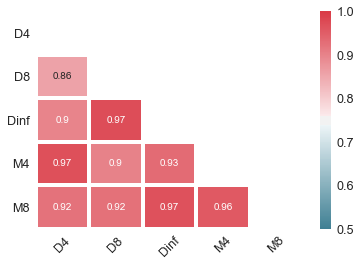

In [231]:
data = c_5m

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=data.columns, mask=mask,
                         yticklabels=data.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [ ]:
correlation_dict = {}

In [ ]:
#correlation_dict['D4/D8'] = [c.iloc[1,0], c_2m.iloc[1,0], c_3m.iloc[1,0], c_4m.iloc[1,0], c_5m.iloc[1,0]]
#correlation_dict['D4/Dinf'] = [c.iloc[2,0], c_2m.iloc[2,0], c_3m.iloc[2,0], c_4m.iloc[2,0], c_5m.iloc[2,0]]
#correlation_dict['D4/M4'] = [c.iloc[3,0], c_2m.iloc[3,0], c_3m.iloc[3,0], c_4m.iloc[3,0], c_5m.iloc[3,0]]
correlation_dict['D4/M8'] = [c.iloc[4,0], c_2m.iloc[4,0], c_3m.iloc[4,0], c_4m.iloc[4,0], c_5m.iloc[4,0]]
#correlation_dict['D8/Dinf'] = [c.iloc[2,1], c_2m.iloc[2,1], c_3m.iloc[2,1], c_4m.iloc[2,1], c_5m.iloc[2,1]]
#correlation_dict['D8/M4'] = [c.iloc[3,1], c_2m.iloc[3,1], c_3m.iloc[3,1], c_4m.iloc[3,1], c_5m.iloc[3,1]]
correlation_dict['D8/M8'] = [c.iloc[4,1], c_2m.iloc[4,1], c_3m.iloc[4,1], c_4m.iloc[4,1], c_5m.iloc[4,1]]
#correlation_dict['Dinf/M4'] = [c.iloc[3,2], c_2m.iloc[3,2], c_3m.iloc[3,2], c_4m.iloc[3,2], c_5m.iloc[3,2]]
correlation_dict['Dinf/M8'] = [c.iloc[4,2], c_2m.iloc[4,2], c_3m.iloc[4,2], c_4m.iloc[4,2], c_5m.iloc[4,2]]
correlation_dict['M4/M8'] = [c.iloc[4,3], c_2m.iloc[4,3], c_3m.iloc[4,3], c_4m.iloc[4,3], c_5m.iloc[4,3]]

In [ ]:
plt.imshow(grid_nodes, cmap="terrain");
plt.colorbar();

In [268]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [273]:
np_array_to_Geotiff('convergent_gullies_non_adjusted.tif', input_geotiff, 
                    convergence_ids_non_adjusted_nodes, drainage_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
